In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.optimizers import Adam,RMSprop
import datetime as dt
from dateutil.relativedelta import relativedelta
from yahoo_fin.stock_info import get_data,tickers_dow as dow,tickers_nasdaq as nasdaq,tickers_sp500 as sp500,get_premarket_price,get_postmarket_price
from yahoo_fin.options import get_calls,get_puts,get_expiration_dates

2022-12-29 09:32:23.936407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 09:32:25.579163: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-29 09:32:25.579186: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-29 09:32:28.641558: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [2]:
# Step 1: Calculate SMA (20-period)
def get_SMA(closing_prices, days):
    return closing_prices.rolling(days).mean()
# Step 2: Calculate std. deviation (14-period)
def get_std_dev(closing_prices, days):
    return closing_prices.rolling(days).std()
# Step 3: Create Bollinger Bands (1.5 std dev)
def get_BB(closing_prices, SMA_days, std_dev_days, rate):
    sma = get_SMA(closing_prices, SMA_days)
    std_dev = get_std_dev(closing_prices, std_dev_days)
    upper_bollinger = sma + std_dev*rate
    lower_bollinger = sma - std_dev*rate
    return upper_bollinger,lower_bollinger

In [3]:
# Step 1: Calculate EMA (20-period)
def get_EMA(closing_prices, days):
    multiplier = 2 / (days + 1)
    ema = [closing_prices[0]]
    for price,EMA_yesterday in zip(closing_prices[1:],ema):
        ema.append(price * multiplier + EMA_yesterday * (1 - multiplier))
    return ema
# Step 2: Calculate ATR (20-period)
def get_ATR(high_prices,low_prices,closing_prices,days):
    high_low = high_prices-low_prices
    high_close = np.abs(high_prices-closing_prices.shift())
    low_close = np.abs(low_prices-closing_prices.shift())
    ranges = pd.concat([high_low,high_close,low_close],axis=1)
    trueRange = np.max(ranges,axis=1)
    atr = trueRange.rolling(days).sum()/days
    return atr
# Step 3: Calculate Keltner Channel
def get_KC(ema,shift,atr):
    upper_kc = ema + shift*atr
    lower_kc = ema - shift*atr
    return upper_kc,lower_kc

In [4]:
def get_momentum(closing_prices,days):
    momentum = []
    for day in range(days):
        momentum.insert(day,None)
    for current_price,previous_price in zip(closing_prices[days:],closing_prices):
        momentum.append(current_price - previous_price)
    return momentum

In [5]:
def gather_data(data):
    if not isinstance(data,pd.core.frame.DataFrame):
        df = pd.read_csv(data)
    else:
        df = data
    closing_prices = df['close']
    high_prices = df['high']
    low_prices = df['low']
    df['SMA'] = get_SMA(closing_prices,20)
    df['EMA'] = get_EMA(closing_prices,20)
    df['ATR'] = get_ATR(high_prices,low_prices,closing_prices,14)
    df['upper_KC'],df['lower_KC'] = get_KC(df['EMA'],1.5,df['ATR'])
    df['bollinger_up'],df['bollinger_down'] = get_BB(closing_prices,20,14,1.5)
    df['MA'] = get_SMA(closing_prices,14)
    df['momentum'] = get_momentum(closing_prices,14)
    return df

# ML Predictions PART 1: Data Pre-Processing

In [6]:
# Step 1: Read data
today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=5))
ticker = 'AMD'
data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
dataset_train = gather_data(data)
# Select features to be involved in training and prediction and target to predict
features = list(dataset_train[['open','upper_KC','lower_KC','bollinger_up','bollinger_down','MA']])#,'high','low','volume','momentum' REMOVED DUE TO NON-LINEARITY
dataset_train['next-day-close']=dataset_train['close'].shift(-1)#shift by 1 days to get the closing price next day
dataset_train['2-day-close']=dataset_train['close'].shift(-2)#shift by 2 days to get the closing price 2 days later
dataset_train['3-day-close']=dataset_train['close'].shift(-3)#shift by 3 days to get the closing price 3 days later
dataset_train['same-day-roi']=((dataset_train['close']-dataset_train['open'])/dataset_train['open'])*100
dataset_train['next-day-roi']=((dataset_train['next-day-close']-dataset_train['open'])/dataset_train['open'])*100
dataset_train['2-day-roi']=((dataset_train['2-day-close']-dataset_train['open'])/dataset_train['open'])*100
dataset_train['3-day-roi']=((dataset_train['3-day-close']-dataset_train['open'])/dataset_train['open'])*100
target = list(dataset_train[['3-day-roi']])#target = list(dataset_train[['close']])
dataset_train.dropna(inplace=True) # THIS IS THE WORST WAY TO DEAL WITH N/A VALUES. KNN DOES NOT WORK AS FIRST VALUES ARE NaN. DOING MEDIAN
X = dataset_train[features]
y = dataset_train[target]
# Scale data
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features].values)
# Split the data for train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f'X_train:\n{X_train}\n\nX_test:\n{X_test}\n\ny_train:\n{y_train}\n\ny_test:\n{y_test}')

(988, 6) (248, 6) (988, 1) (248, 1)
X_train:
                open  upper_KC  lower_KC  bollinger_up  bollinger_down  \
2018-10-05 -0.916650 -0.853379 -0.888640     -0.813703       -0.841447   
2018-07-16 -1.234134 -1.247710 -1.235327     -1.238733       -1.229728   
2022-05-06  0.889330  0.952225  0.877761      0.857439        0.852140   
2022-10-17 -0.118716  0.126787  0.060917      0.155389        0.014473   
2019-01-03 -1.179630 -1.145904 -1.184770     -1.149242       -1.159466   
...              ...       ...       ...           ...             ...   
2022-01-05  2.210499  2.291331  2.258812      2.194098        2.264665   
2019-08-20 -0.838437 -0.798754 -0.836738     -0.796157       -0.823965   
2020-05-05 -0.225543 -0.227249 -0.257592     -0.222290       -0.198825   
2020-02-06 -0.351719 -0.352758 -0.330612     -0.357359       -0.283923   
2019-12-16 -0.544389 -0.617809 -0.566599     -0.605763       -0.551557   

                  MA  
2018-10-05 -0.836926  
2018-07-16 -1.243561

/tmp/ipykernel_1166637/2759313220.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features] = scaler.fit_transform(X[features].values)


# Check for linearity

In [7]:
for feature in features:
    slope, intercept, r_value, p_value, std_err = stats.linregress(dataset_train[feature], dataset_train['3-day-roi'])
    print(f'At {feature}, r_value: {r_value**2}')
# slope, intercept, r_value, p_value, std_err = stats.linregress(dataset_train['volume'], dataset_train['close'])
# print(f'At volume, r_value: {r_value**2}')
# slope, intercept, r_value, p_value, std_err = stats.linregress(dataset_train['momentum'], dataset_train['close'])
# print(f'At momentum, r_value: {r_value**2}')

At open, r_value: 0.012274557510028246
At upper_KC, r_value: 0.011885765170099177
At lower_KC, r_value: 0.011607719830544204
At bollinger_up, r_value: 0.012351266820210899
At bollinger_down, r_value: 0.012682549375200743
At MA, r_value: 0.011976992614188189


Surprisingly, we see that Volume and Momentum are correlated very little to Closing prices. Only 0.010511741252537113 for volume and 0.02194343991238041 for momentum.
Remember, r_value is between 0 and 1, where 0 is bad and 1 is good

# Now plot everything to double check for linearity at those values

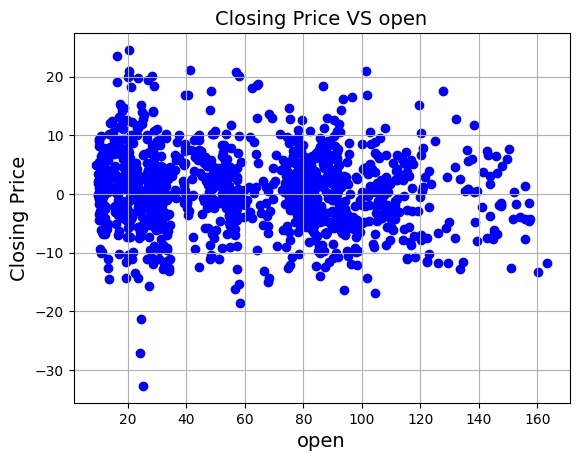

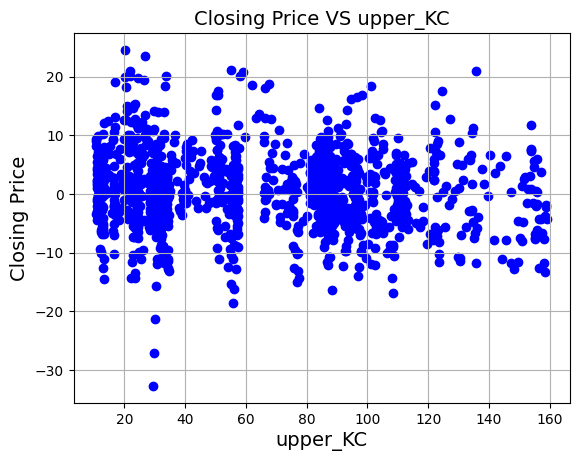

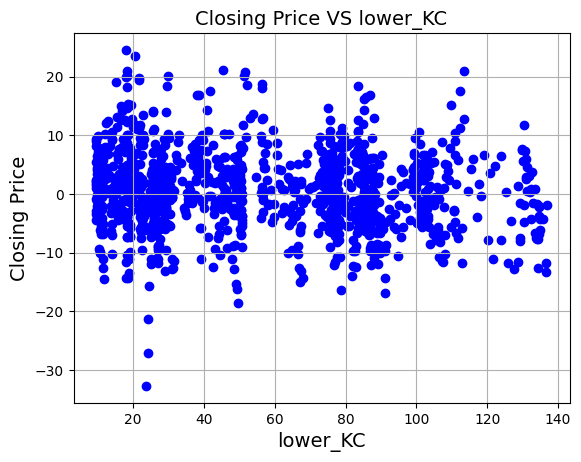

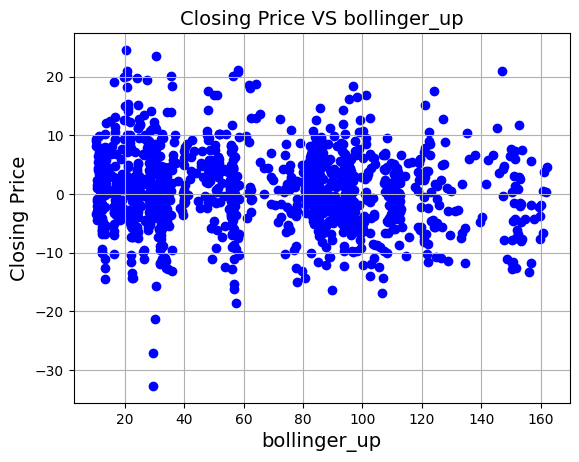

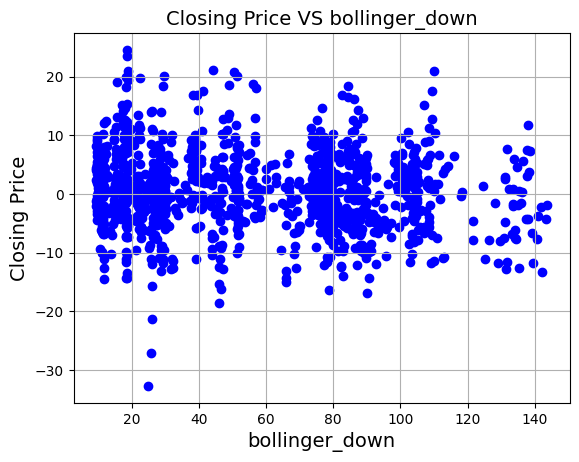

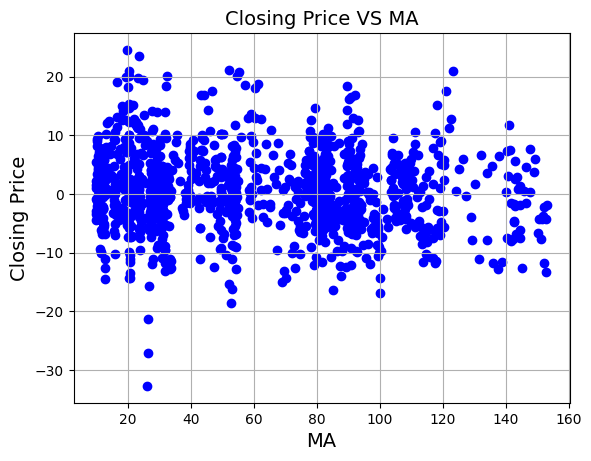

In [8]:
%matplotlib inline

for feature in features:
    plt.scatter(dataset_train[feature], dataset_train['3-day-roi'], color='blue')
    plt.title(f'Closing Price VS {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Closing Price', fontsize=14)
    plt.grid(True)
    plt.show()

# Perform Multiple Linear Regression

In [9]:
# Train model using train data:
X_train = sm.add_constant(X_train) # adding a constant

RLMmodel = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT()).fit()
OLSmodel = sm.OLS(y_train, X_train).fit()
print(RLMmodel.summary())
# Make predictions on test data
X_test = sm.add_constant(X_test)
predictions = RLMmodel.predict(X_test)
# for real,prediction in zip(y_test.values,predictions):
#     print(f'\nReal data: {real}. Predicted value: {prediction}')

#from sklearn.metrics import accuracy_score # THIS IS USED FOR CLASSIFIERS
print(f'r2 score: {r2_score(y_test,predictions)}')
# print(f'\nPredictions: {predictions}')
# print(f'\nActual data: {y_test}')


                    Robust linear Model Regression Results                    
Dep. Variable:              3-day-roi   No. Observations:                  988
Model:                            RLM   Df Residuals:                      981
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 29 Dec 2022                                         
Time:                        09:32:51                                         
No. Iterations:                    13                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4822      0.197      2.

In [10]:
# Let's try making a prediction
open = 113.91
keltner_up = 117.32
keltner_down = 109.53
bb_up = 115.49
bb_down = 110.9
ma = 113.2
real_data_today = scaler.transform([[open,keltner_up,keltner_down,bb_up,bb_down,ma]])
real_data_today = np.insert(real_data_today[0], 0, 1) # Add constant like in the model to add a y-int
predicted = RLMmodel.predict(real_data_today)
print(f'Price of {ticker} should go to ${predicted[0]} in 3 days')

Price of AMD should go to $0.7059924371626718 in 3 days
